# A statistical approach in a multiple choice assessment evaluation process

Author: [Aleksandr Saiapin](alstutor@gmail.com), [Siberian State University of Science and Technologies](http://en.sibsau.ru/) (former Siberain State Aerospace University), Krasnoyarsk, Russia

It is an additional material notebook for the article.

## Abstract

The purpose of the study is to estimate the distribution of multiple choice assessment results to improve the quality of the new developing assessments. The study uses a statistical approach to an assessment result evaluation. The proposed method can be used to refine the assessment pass threshold value both for existing and new developing assessments. The results of the work may be useful for university teachers, tutors and mentors, especially for massive open online course systems staff.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In [1]:
import random

# single answer function
def answer_item(answers_num=1, distractors_num=1):
    """Simulate passing one task of the assessment
    
    :param answers_num: the number of the answers in the particular task
    :param distractors_num: the number of the distractors in the particular task
    :return: the number of the answers, the number of marked answers, the number of the distractors, the number of the non-marked distractors
    """
    
    correct_answers = random.sample(range(answers_num + distractors_num), answers_num)
    user_answers = random.sample(range(answers_num + distractors_num), 1 if answers_num == 1 else random.choice(range(answers_num + distractors_num)))
    
    correct_answers_num = 0
    correct_distractors_num = 0
    for i in range(answers_num + distractors_num):
        correct_answers_num += 1 if i in correct_answers and i in user_answers else 0
        correct_distractors_num += 1 if i not in correct_answers and i not in user_answers else 0
        
    return answers_num, correct_answers_num, distractors_num, correct_distractors_num

In [2]:
# assessement function
def assesst(items_num=12, assesst_props=[{'answers_num': 1, 'distractors_num': 1}], choice=False,
            score_function=lambda answers_num, correct_answers_num, distractors_num, correct_distractors_num:
            float(correct_answers_num + correct_distractors_num) / float(answers_num + distractors_num)):
    """Simulate single assessment
    """
    if choice and len(assesst_props) != items_num:
        raise KeyError('The length of the assesst_props and the items_num should be the same!')

    answers_num, correct_answers_num, distractors_num, correct_distractors_num = 0, 0, 0, 0
    for i in range(items_num):
        cur_item = random.choice(assesst_props)

        if choice:
            assesst_props.remove(cur_item)

        a_num, c_a_num, d_num, c_d_num = answer_item(cur_item['answers_num'], cur_item['distractors_num'])
        answers_num += a_num
        correct_answers_num += c_a_num
        distractors_num += d_num
        correct_distractors_num += c_d_num

    return score_function(answers_num, correct_answers_num, distractors_num, correct_distractors_num)

In [3]:
#my own binomial distribution function for checking the type of the distribution
from scipy import stats

def bin_distr(x, n, p, loc): # param: n, p, loc
    """Scaled probability mass function"""
    return stats.binom.pmf(x, n=n, p=p, loc=loc)    

In [4]:
#loss function for the fitting of the parameters of the binomial distribution
import math

def m_func(param, x=[], y=[]):
    """Loss function"""
    sum = 0
    for i in range(len(x)):
        sum += math.pow(y[i] - bin_distr(i, param[0], param[1], param[2]), 2)
        
    return sum

[ 11.     0.45   0.  ]
0.0512922703291
[  3  12  56 111 202 233 179 127  56  17   2   1]
[  1  12  51 125 205 235 192 112  46  12   2   0]
[ 15  56 111 202 233 179 127  56  20]
[ 13  51 125 205 235 192 112  46  14]
0.260750452066


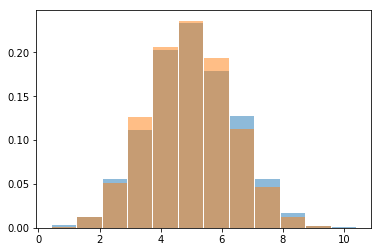

In [5]:
# let's check the type of the distribution for answers num=1 and distractors num=1

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':1}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(m_func, (slice(5, 20, 1), slice(0.2, 0.6, 0.05), slice(-10, 10, 5)), args=(values, hist,), finish=None)
print(res)

computed = [bin_distr(x, res[0], res[1], res[2]) for x in range(len(values))]
print(bin_distr(2, res[0], res[1], res[2]))

plt.bar(values * 10, hist, alpha=0.5)
plt.bar(values * 10, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

[ 11.     0.35   0.  ]
0.139546512745
[ 10  42 156 228 228 182 103  36  11   3]
[  8  51 139 225 242 182  98  37  10   1]
[ 10  42 156 228 228 182 103  36  14]
[  8  51 139 225 242 182  98  37  11]
0.63406071063


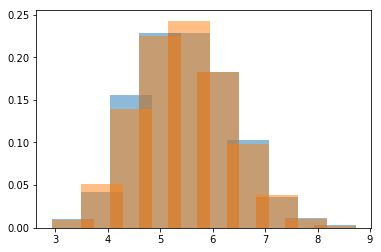

In [6]:
# let's check the type of the distribution for answers num=1 and distractors num=2

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':2}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(m_func, (slice(5, 20, 1), slice(0.1, 0.9, 0.05), slice(-10, 10, 5)), args=(values, hist,), finish=None)
print(res)

computed = [bin_distr(x, res[0], res[1], res[2]) for x in range(len(values))]
print(bin_distr(2, res[0], res[1], res[2]))

plt.bar(values * 10, hist, alpha=0.5)
plt.bar(values * 10, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

[ 12.     0.25   0.  ]
0.232293248177
[ 28 123 236 278 172 100  53   7   2]
[ 31 126 232 257 193 103  40  11   2]
[ 28 123 236 278 172 100  53   9]
[ 31 126 232 257 193 103  40  13]
0.190006492707


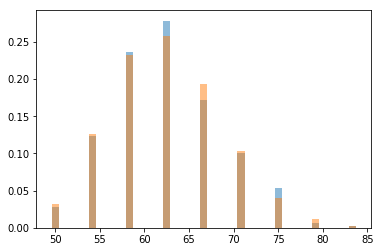

In [7]:
# let's check the type of the distribution for answers num=1 and distractors num=2

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':3}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(m_func, (slice(3, 30, 1), slice(0.1, 0.9, 0.05), slice(-10, 10, 5)), args=(values, hist,), finish=None)
print(res)

computed = [bin_distr(x, res[0], res[1], res[2]) for x in range(len(values))]
print(bin_distr(2, res[0], res[1], res[2]))

plt.bar(values * 100, hist, alpha=0.5)
plt.bar(values * 100, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

p-value is significally higher than $\alpha=0.05$ value.

In [8]:
#my own poisson distribution function for checking the type of the distribution
from scipy import stats

def pbin_distr(x, mu, loc): # param: n, p, loc
    """Scaled probability mass function"""
    return stats.poisson.pmf(x, mu, loc=loc)    

In [9]:
#loss function for the fitting of the parameters of the poisson distribution
import math

def pm_func(param, x=[], y=[]):
    """Loss function"""
    sum = 0
    for i in range(len(x)):
        sum += math.pow(y[i] - pbin_distr(i, param[0], param[1]), 2)
        
    return sum

[ 9.  0.]
0.00499809706551
[  1   5   4  14  27  59  86 110 125 141 131 101  72  64  26  12  10  10
   1]
[  0   1   4  14  33  60  90 116 131 131 118  96  72  50  32  19  10   5
   2]
[ 10  14  27  59  86 110 125 141 131 101  72  64  26  12  10  11]
[  5  14  33  60  90 116 131 131 118  96  72  50  32  19  10   7]
0.203231586542


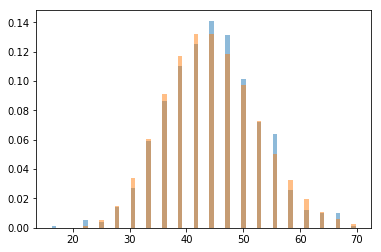

In [10]:
# let's check the type of the distribution for answers num=2 and distractors num=1

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':2, 'distractors_num':1}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(pm_func, (slice(1, 30, 1), slice(-10, 10, 1)), args=(values, hist,), finish=None)
print(res)

computed = [pbin_distr(x, res[0], res[1]) for x in range(len(values))]
print(pbin_distr(2, res[0], res[1]))

plt.bar(values * 100, hist, alpha=0.5)
plt.bar(values * 100, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

[ 11.  -1.]
0.00370499395864
[  2   1   4  12  26  48  51 101 102 118 107 124  94  79  45  32  22  20
   4   5   1   1]
[  0   1   3  10  22  41  64  88 108 119 119 109  92  72  53  36  23  14
   8   4   2   1]
[ 19  26  48  51 101 102 118 107 124  94  79  45  32  22  31]
[ 14  22  41  64  88 108 119 119 109  92  72  53  36  23  29]
0.417279562617


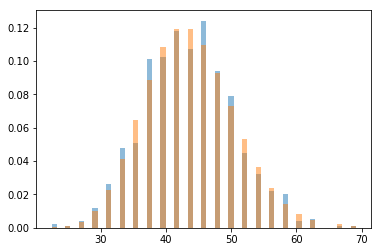

In [11]:
# let's check the type of the distribution for answers num=3 and distractors num=1

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':3, 'distractors_num':1}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(pm_func, (slice(1, 30, 1), slice(-10, 10, 1)), args=(values, hist,), finish=None)
print(res)

computed = [pbin_distr(x, res[0], res[1]) for x in range(len(values))]
print(pbin_distr(2, res[0], res[1]))

plt.bar(values * 100, hist, alpha=0.5)
plt.bar(values * 100, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

[ 13.  -2.]
0.0026898861747
[  1   1   4   6  20  27  53  85  80  88  96 125 114  80  75  53  27  26
  19   9   4   3   1   1   1]
[  0   0   2   6  15  28  45  65  85 101 109 109 101  88  71  54  39  27
  17  10   6   3   1   1   0]
[ 12  20  27  53  85  80  88  96 125 114  80  75  53  27  26  19  19]
[  8  15  28  45  65  85 101 109 109 101  88  71  54  39  27  17  21]
0.0907249733632


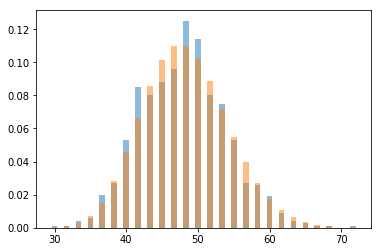

In [13]:
# let's check the type of the distribution for answers num=3 and distractors num=2

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import brute

assessments_num = 999

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':3, 'distractors_num':2}]))
    
values = np.unique(assessments)
values1 = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values1)

hist_sum = np.sum(hist)

hist = hist / hist_sum

res = brute(pm_func, (slice(1, 30, 1), slice(-10, 10, 1)), args=(values, hist,), finish=None)
print(res)

computed = [pbin_distr(x, res[0], res[1]) for x in range(len(values))]
print(pbin_distr(2, res[0], res[1]))

plt.bar(values * 100, hist, alpha=0.5)
plt.bar(values * 100, computed, alpha=0.5)

# restore the number of the elements in histogram
hist = (hist * hist_sum).astype(int) # convert the array type into int
# and compute the corresponding elements number fot the theoretical distribution
computed = (np.array(computed) * hist_sum).astype(int) #  the same to computed array
print(hist)
print(computed)

# prepare hist and computed arrays to chisquare test
found = True
while found:
    found = False
    for i in range(len(hist)):
        if hist[i] < 5 or computed[i] < 5:
            found = True
            if i > 0:
                hist[i - 1] += hist[i]
                hist = np.delete(hist, i)

                computed[i - 1] += computed[i]
                computed = np.delete(computed, i)
            else:
                hist[i + 1] += hist[i]
                hist = np.delete(hist, i)
                
                computed[i + 1] += computed[i]
                computed = np.delete(computed, i)
            break

print(hist)
print(computed)
statistic, pvalue = stats.chisquare(hist, computed)
print(pvalue)

<IPython.core.display.Javascript object>


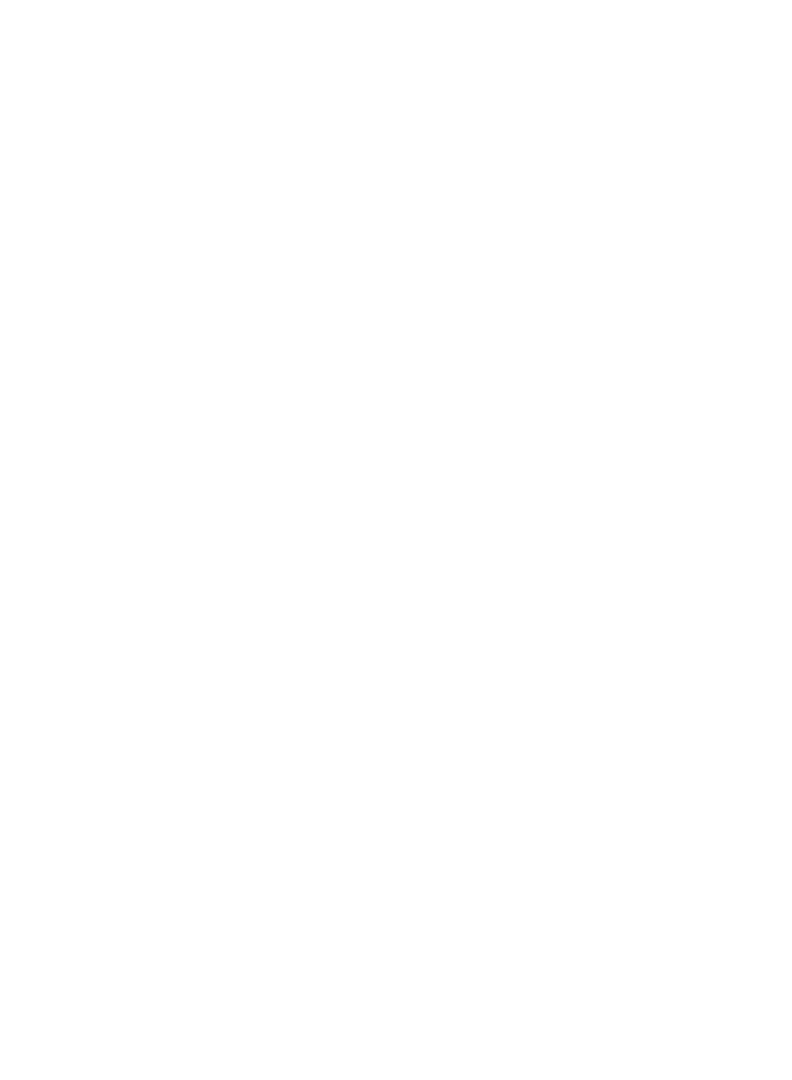

<IPython.core.display.Javascript object>


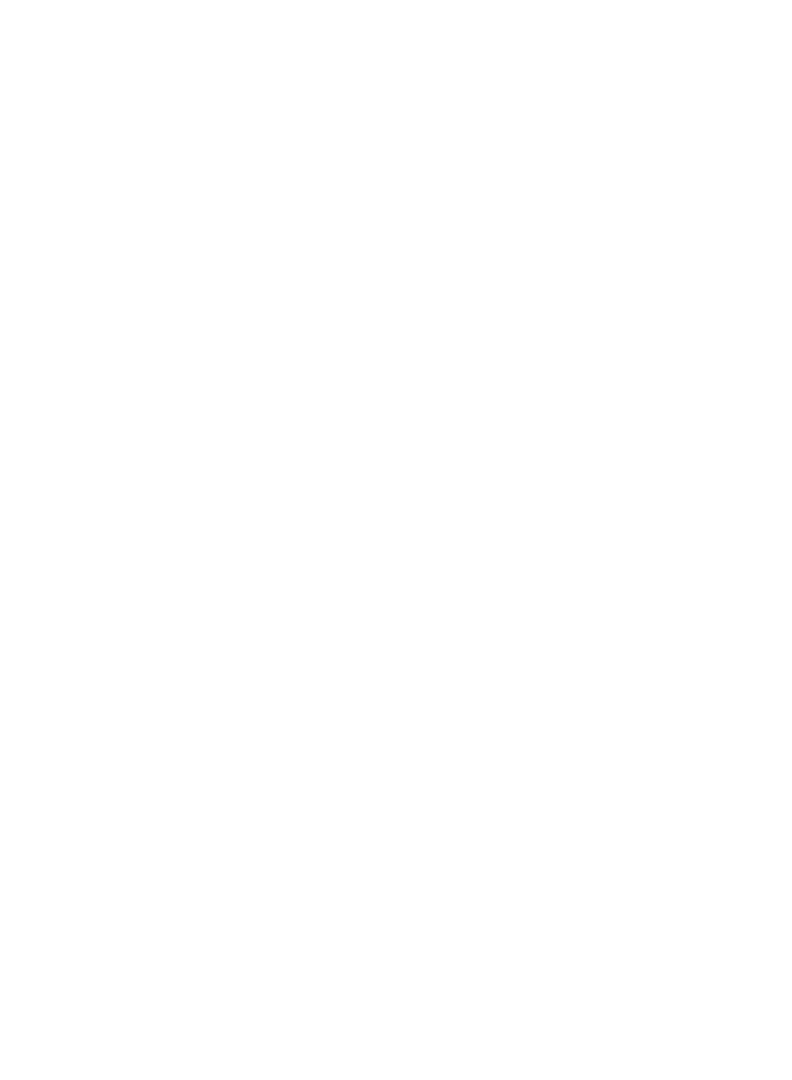

In [14]:
#now we are going to check the distribution types for the different answer/distractors rate

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assessments_num = 100000

answers_nums = [1, 2, 3]
distractors_nums = [1, 2, 3, 4]

fig, axes = plt.subplots(nrows=len(distractors_nums), ncols=len(answers_nums), figsize=(11, 15))

for distractors_num in distractors_nums:
    for answers_num in answers_nums:
        axes_code = axes[distractors_num - 1, answers_num - 1]
        
        assessments = []
        for i in range(assessments_num):
            assessments.append(assesst(assesst_props=[{'answers_num':answers_num, 'distractors_num':distractors_num}]))
        
        title = "A={}, D={}".format(answers_num, distractors_num)
        
        values = np.unique(assessments)
        values = np.append(values, [1.1])

        hist, bins = np.histogram(assessments, bins=values)
        ticks = ["{:04.2f}".format(val) for val in values[:-1]]

        axes_code.bar(values[:-1] * 100, hist, align='center', alpha=0.5)
        #axes_code.xticks(values[:-1] * 100, ticks)
        #axes_code.set_xticks(values[:-1] * 100)
        #axes_code.set_xticklabels(ticks)
        axes_code.set_title(title)

[ 0.24324324  0.28947368  0.3         0.30555556  0.30769231  0.31428571
  0.31578947  0.32352941  0.32432432  0.3255814   0.33333333  0.34146341
  0.34210526  0.34285714  0.34883721  0.35        0.35135135  0.35294118
  0.35555556  0.35714286  0.35897436  0.36111111  0.36170213  0.36363636
  0.36585366  0.36842105  0.36956522  0.37142857  0.37209302  0.375
  0.37837838  0.38095238  0.38461538  0.38636364  0.38888889  0.3902439
  0.39473684  0.39534884  0.39583333  0.4         0.40425532  0.4047619
  0.40540541  0.40816327  0.40909091  0.41025641  0.41176471  0.41304348
  0.41463415  0.41666667  0.41860465  0.42105263  0.42222222  0.425
  0.42553191  0.42857143  0.43181818  0.43243243  0.43478261  0.43589744
  0.43902439  0.44        0.44186047  0.44444444  0.44680851  0.44736842
  0.45        0.45098039  0.4516129   0.45238095  0.45454545  0.45652174
  0.45714286  0.45945946  0.46        0.46153846  0.46341463  0.46511628
  0.46666667  0.46875     0.46938776  0.47058824  0.47222222  0

<IPython.core.display.Javascript object>


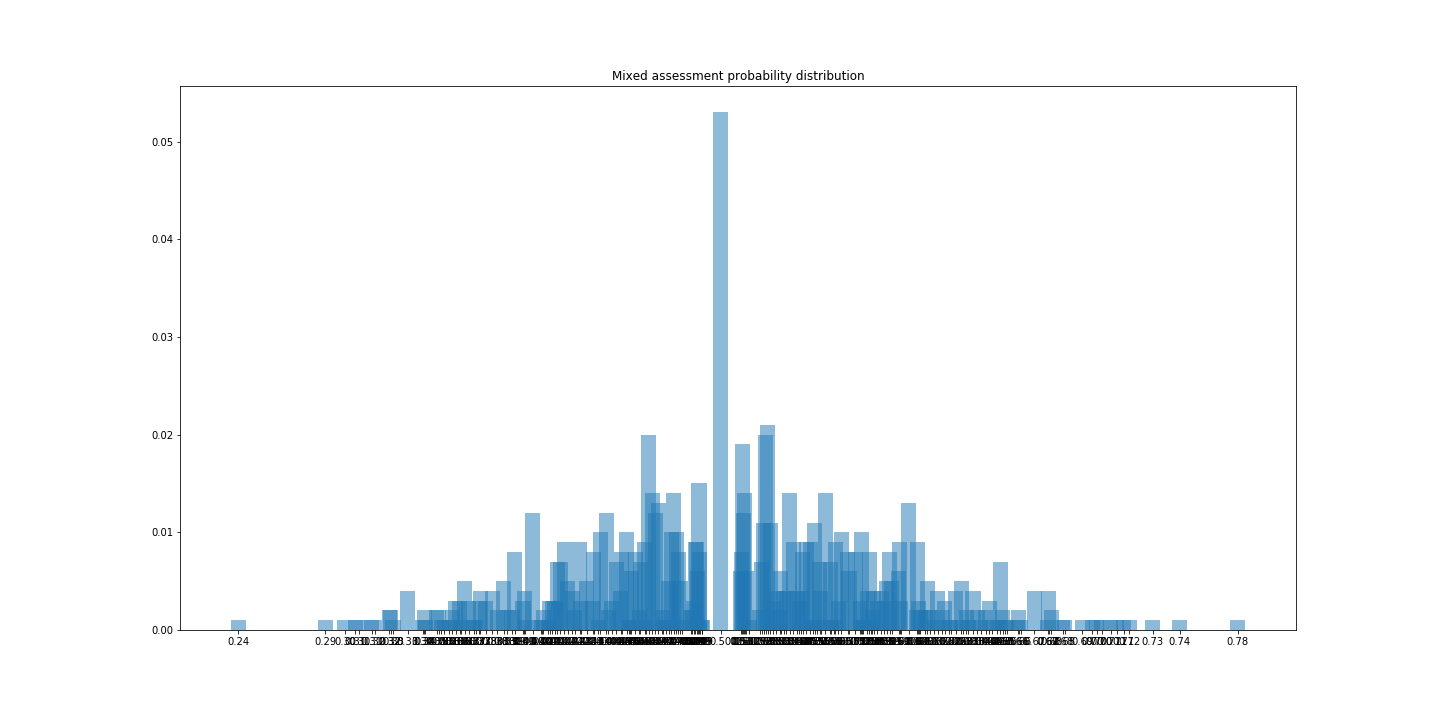

In [21]:
# Let's check mixed type of assessment
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assessments_num = 1000

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':1}, {'answers_num':1, 'distractors_num':2}, {'answers_num':2, 'distractors_num':1}, {'answers_num':2, 'distractors_num':2}, {'answers_num':2, 'distractors_num':3}]))
        
values = np.unique(assessments)
print(values)
print(len(values))
values = np.append(values, [1.1])

hist, bins = np.histogram(assessments, bins=values)
ticks = ["{:04.2f}".format(val) for val in values[:-1]]

hist = hist / np.sum(hist)

plt.figure(figsize=(20,10))
plt.bar(values[:-1] * 100, hist, align='center', alpha=0.5)
plt.xticks(values[:-1] * 100, ticks)
#plt.set_xticklabels(ticks)
plt.title("Mixed assessment probability distribution")
plt.show()

<IPython.core.display.Javascript object>


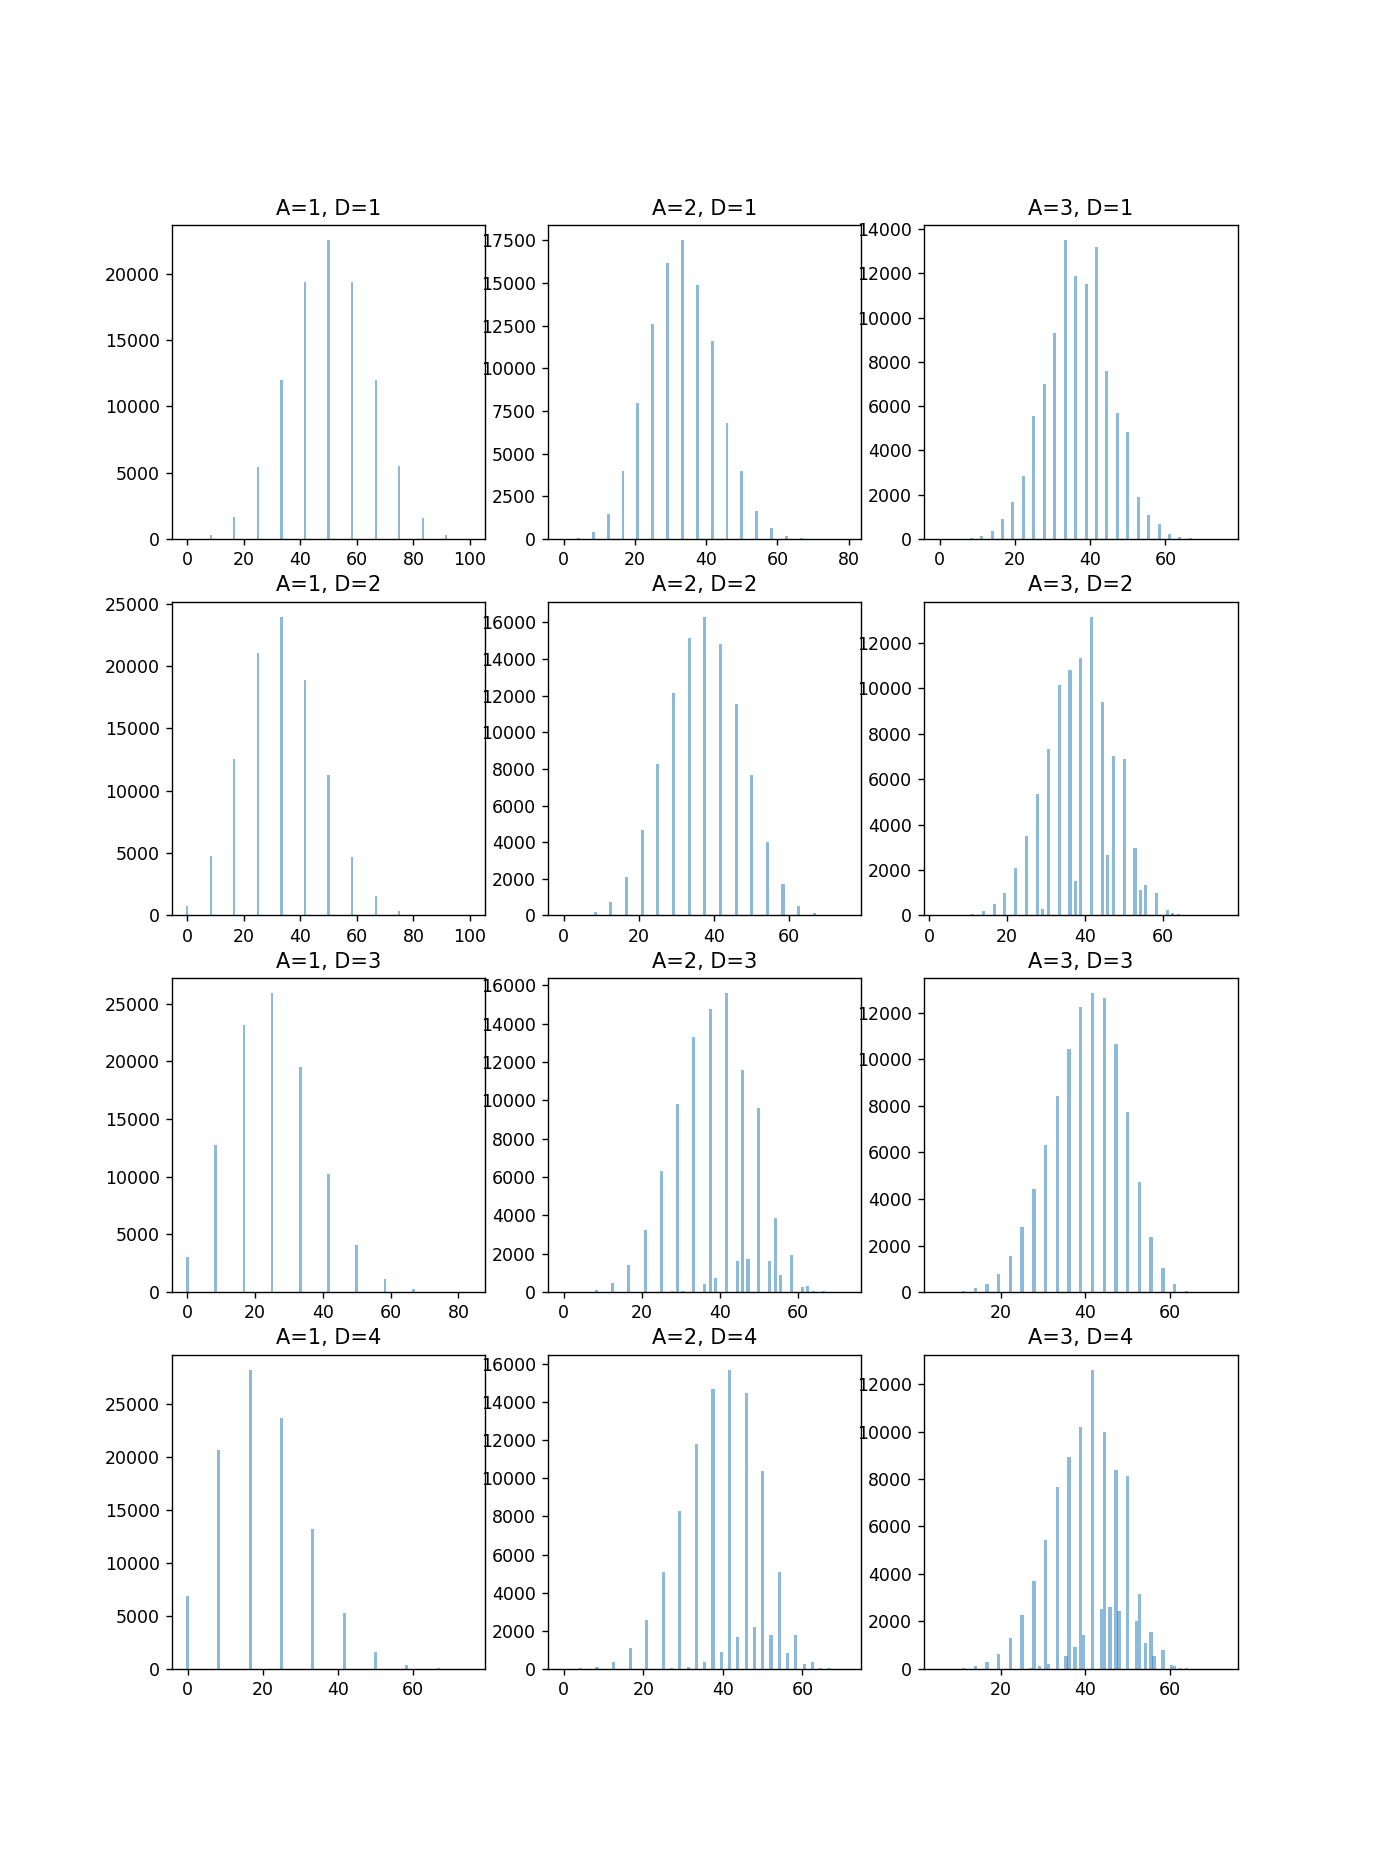

In [4]:
# the old version of the score calculating function, the distributions are presented here

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

assessments_num = 100000

answers_nums = [1, 2, 3]
distractors_nums = [1, 2, 3, 4]

fig, axes = plt.subplots(nrows=len(distractors_nums), ncols=len(answers_nums), figsize=(11, 15))

for distractors_num in distractors_nums:
    for answers_num in answers_nums:
        axes_code = axes[distractors_num - 1, answers_num - 1]
        
        assessments = []
        for i in range(assessments_num):
            assessments.append(assesst(assesst_props=[{'answers_num':answers_num, 'distractors_num':distractors_num}], score_function=lambda answers_num, correct_answers_num, distractors_num, correct_distractors_num: min([float(correct_answers_num) / float(answers_num), float(correct_distractors_num) / float(distractors_num)])))
        
        title = "A={}, D={}".format(answers_num, distractors_num)
        
        values = np.unique(assessments)
        values = np.append(values, [1.1])

        hist, bins = np.histogram(assessments, bins=values)
        ticks = ["{:04.2f}".format(val) for val in values[:-1]]

        axes_code.bar(values[:-1] * 100, hist, align='center', alpha=0.5)
        #axes_code.xticks(values[:-1] * 100, ticks)
        #axes_code.set_xticks(values[:-1] * 100)
        #axes_code.set_xticklabels(ticks)
        axes_code.set_title(title)
# as you can see, the distributions do not belong to any known type except for the one-answer distributions

In [42]:
# function to compute the thershold level
import copy

def threshold_def(assessment=[{'task_num': 4, 'answers_num': 1, 'distractors_num':1}, {'task_num': 4, 'answers_num': 2, 'distractors_num':2}, {'task_num': 4, 'answers_num': 1, 'distractors_num':3}], test_num=15000, alpha=0.05):
    tasks_list = []
    tasks_num = 0
    for descr in assessment:
        for i in range(descr['task_num']):
            tasks_list.append({'answers_num': descr['answers_num'], 'distractors_num': descr['distractors_num']})
            tasks_num += 1
            
    assessments = []
    for i in range(test_num):
        tasks_list1 = copy.copy(tasks_list)
        assessments.append(assesst(items_num=tasks_num, assesst_props=tasks_list1, choice=True))
    
    values = np.unique(assessments)
    values1 = np.append(values, [1.1])

    hist, bins = np.histogram(assessments, bins=values1)

    hist_sum = np.sum(hist)

    hist = hist / hist_sum
    
    rev_hist = list(reversed(hist))
    rev_values = list(reversed(values))
    threshold = values[-1]
    threshold_sum = 0
    for i in range(len(rev_hist)):
        threshold_sum += rev_hist[i]
        if threshold_sum > alpha:
            threshold = rev_values[i]
            break

    return threshold

In [43]:
#now test it with default values

threshold_def()

0.67500000000000004

In [45]:
# now check the assessment with 12 tasks where every one of them has 1 answer and 1 distractor

threshold_def(assessment=[{'task_num': 12, 'answers_num': 1, 'distractors_num':1}])

0.75

In [46]:
# now check the assessment with 12 tasks where every one of them has 1 answer and 2 distractors

threshold_def(assessment=[{'task_num': 12, 'answers_num': 1, 'distractors_num':2}])

0.72222222222222221

In [3]:
import pandas as pd
import numpy as np
from scipy import stats

# distribution type check function
def norm_distr_type_check(data, p=0.05):
    """Check if the given distribution a normal distribution"""
    data_mean = data.mean()
    data_std = data.std()
    size = len(data)
    
    values = np.unique(assessments)
    values = np.append(values, [1.1])

    data_hist, data_bin_edges = np.histogram(assessments, bins=values)
    
    found = True
    while found:
        found = False
        for i in range(len(data_hist)):
            if data_hist[i] < 5:
                found = True
                if i > 0:
                    data_hist[i - 1] += data_hist[i]
                    data_hist = np.delete(data_hist, i)
                    data_bin_edges = np.delete(data_bin_edges, i)
                else:
                    data_hist[i + 1] += data_hist[i]
                    data_hist = np.delete(data_hist, i)
                    data_bin_edges = np.delete(data_bin_edges, i + 1)
                break
            
    #print(data_hist)
    #print(data_bin_edges)
    
    theor_data = []
    for i in range(len(data_hist)):
        theor_data.append(stats.norm.pdf(data_bin_edges[i], loc=data_mean, scale=data_std))
        
    coeff = float(size) / np.sum(theor_data)
    
    theor_data = np.array(theor_data) * coeff
    
    statistic, pvalue = stats.chisquare(data_hist, theor_data)
    
    return pvalue > p, statistic, data_hist, theor_data, data_bin_edges

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# distribution type check function
def distr_type_check(data, distr, p=0.05):
    """Check if the given distribution a given distribution"""
    param = distr.fit(data)
    arg = param[:-2]
    loc = param[-2]
    scale = param[-1]
    size = len(data)
    
    values = np.unique(assessments)
    values = np.append(values, [1.1])

    data_hist, data_bin_edges = np.histogram(assessments, bins=values)
    
    found = True
    while found:
        found = False
        for i in range(len(data_hist)):
            if data_hist[i] < 5:
                found = True
                if i > 0:
                    data_hist[i - 1] += data_hist[i]
                    data_hist = np.delete(data_hist, i)
                    data_bin_edges = np.delete(data_bin_edges, i)
                else:
                    data_hist[i + 1] += data_hist[i]
                    data_hist = np.delete(data_hist, i)
                    data_bin_edges = np.delete(data_bin_edges, i + 1)
                break
            
    theor_data = []
    for i in range(len(data_hist)):
        #theor_data.append(distr.pdf(data_bin_edges[i], loc=param[0], scale=param[1]))
        if arg:
            theor_data.append(distr.pdf(data_bin_edges[i], arg, loc=loc, scale=scale))
        else:
            theor_data.append(distr.pdf(data_bin_edges[i], loc=loc, scale=scale))
        
    coeff = float(size) / np.sum(theor_data)
    
    theor_data = np.array(theor_data) * coeff
    
    statistic, pvalue = stats.chisquare(data_hist, theor_data)
    
    return pvalue > p, statistic, data_hist, theor_data, data_bin_edges

[ 0.6         0.63333333  0.66666667  0.7         0.73333333  0.76666667
  0.8         0.83333333  1.1       ]
[ 0.062  0.196  0.309  0.217  0.137  0.06   0.015  0.004]


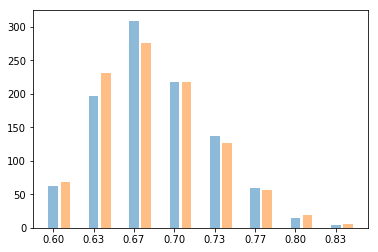

In [5]:
# just out of curiosity I've checked if the distribution is of rayleigh type

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

assessments_num = 1000
bins_num = 15

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':4}]))
    
values = np.unique(assessments)
values = np.append(values, [1.1])
print(values)

r_param = stats.rayleigh.fit(assessments)
r_theor_data = []
for i in range(len(values[:-1])):
    r_theor_data.append(stats.rayleigh.pdf(values[i], loc=r_param[0], scale=r_param[1]))
       
coeff = float(assessments_num) / np.sum(r_theor_data)
    
r_theor_data = np.array(r_theor_data) * coeff

hist, bins = np.histogram(assessments, bins=values)
print(hist / np.sum(hist))
ticks = ["{:04.2f}".format(val) for val in values[:-1]]

plt.bar(values[:-1] * 100, hist, align='center', alpha=0.5)
plt.bar(values[:-1] * 100 + 1, r_theor_data, align='center', alpha=0.5)
plt.xticks(values[:-1] * 100, ticks)
plt.show()

In [33]:
###############################################
#rayleigh distribution! {'answers_num':1, 'distractors_num':4}
###############################################

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

assessments_num = 1000

assessments = []
for i in range(assessments_num):
    assessments.append(assesst(assesst_props=[{'answers_num':1, 'distractors_num':4}]))
    
#distr_type_check(assessments, stats.norm)
distr_type_check(assessments, stats.rayleigh)

(True,
 10.302287206054709,
 array([ 66, 218, 316, 201, 132,  48,  19]),
 array([  74.7902912 ,  242.02530218,  281.26784368,  214.67349919,
         119.76523861,   50.79229271,   16.68553243]),
 array([ 0.6       ,  0.63333333,  0.66666667,  0.7       ,  0.73333333,
         0.76666667,  0.8       ,  1.1       ]))

Yes, it is, but only for 1 answer/4 distractors assessment